In [ ]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [ ]:
data = yf.download('USDINR=X', start='2004-01-01', end='2023-02-01')
df = pd.DataFrame(data)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-01,45.528999,45.532001,45.519001,45.527000,45.527000,0
2004-01-02,45.527000,45.645000,45.497002,45.603001,45.603001,0
2004-01-05,45.528000,45.564999,45.459000,45.466000,45.466000,0
2004-01-06,45.467999,45.604000,45.457001,45.549000,45.549000,0
2004-01-07,45.548000,45.560001,45.375000,45.387001,45.387001,0


In [ ]:
tdf = df.asfreq(freq='MS', method='ffill')
tdf.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-01,45.528999,45.532001,45.519001,45.527000,45.527000,0
2004-02-01,45.261002,45.292999,45.004002,45.004002,45.004002,0
2004-03-01,45.165001,45.195000,45.105000,45.173000,45.173000,0
2004-04-01,43.331001,43.404999,43.275002,43.373001,43.373001,0
2004-05-01,44.312000,44.439999,44.270000,44.284000,44.284000,0


In [ ]:
tdf.drop(columns=['Open','High','Low','Adj Close','Volume'],inplace=True)

In [ ]:
tdf.rename(columns= {'Close': 'USD/INR'})

,USD/INR
Date,
2004-01-01,45.527000
2004-02-01,45.004002
2004-03-01,45.173000
2004-04-01,43.373001
2004-05-01,44.284000
...,...
2022-09-01,79.548798
2022-10-01,81.480598
2022-11-01,82.728996


In [ ]:
Y_train_df = tdf.loc[:'2022-01-01']
Y_train_df.shape

(217, 1)

In [ ]:
Y_test_df = tdf.loc['2022-02-01':]
Y_test_df.shape

(12, 1)

In [ ]:
cpi_df = pd.read_csv(filepath_or_buffer = '/content/drive/MyDrive/BTP/CPI Growth Rate India.csv',index_col='DATE')
bop_df = pd.read_csv('/content/drive/MyDrive/BTP/Exports - India seasonally adjusted.csv',index_col="DATE")
ip_df = pd.read_csv('/content/drive/MyDrive/BTP/Industrial Production India Seasonally Adjusted.csv',index_col = "DATE")
ir_in_df = pd.read_csv('/content/drive/MyDrive/BTP/Interest Rate - Call Money Rate - India.csv',index_col = "DATE")
ir_us_df = pd.read_csv('/content/drive/MyDrive/BTP/Interest Rate - Call Money Rate - Us.csv',index_col = "DATE")
print(cpi_df.info())
print(bop_df.info())
print(ip_df.info())
print(ir_in_df.info())
print(ir_us_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 764 entries, 1960-01-01 to 2023-08-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CPALTT01INM659N  764 non-null    float64
dtypes: float64(1)
memory usage: 11.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 1990-01-01 to 2023-08-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   XTEXVA01INM667S  404 non-null    float64
dtypes: float64(1)
memory usage: 6.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 351 entries, 1994-04-01 to 2023-06-01
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   INDPROMANMISMEI  351 non-null    float64
dtypes: float64(1)
memory usage: 5.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 01-01-2004 to 01-08-2023
Data columns (total

In [ ]:
ir_in_df.tail()

,IRSTCI01INM156N
DATE,
01-04-2023,6.75
01-05-2023,6.75
01-06-2023,6.75
01-07-2023,6.75
01-08-2023,6.75


In [ ]:
variables_df = [cpi_df,bop_df,ip_df,ir_in_df,ir_us_df]

In [ ]:
cpi_df.rename(columns={'CPALTT01INM659N':'CPI'},inplace=True)
bop_df.rename(columns={'XTEXVA01INM667S':'BOP'},inplace=True)
ip_df.rename(columns={'INDPROMANMISMEI':'IP'},inplace=True)
ir_in_df.rename(columns={'IRSTCI01INM156N':'IR_IN'},inplace=True)
ir_us_df.rename(columns={'IRSTCI01USM156N':'IR_US'},inplace=True)

In [ ]:
for df in variables_df:
  df.index = pd.to_datetime(df.index)

In [ ]:
cpi_df = cpi_df.asfreq(freq='MS',method='bfill')
bop_df = bop_df.asfreq(freq='MS',method='bfill')
ip_df = ip_df.asfreq(freq='MS',method='bfill')
ir_in_df = ir_in_df.asfreq(freq='MS',method='bfill')
ir_us_df = ir_us_df.asfreq(freq='MS',method='bfill')

In [ ]:
cpi_df_train = cpi_df.loc[pd.to_datetime("2004-01-01"):pd.to_datetime("2022-01-01")]
bop_df_train = bop_df.loc['2004-01-01':'2022-01-01']
ip_df_train = ip_df.loc['2004-01-01':'2022-01-01']
ir_in_df_train = ir_in_df.loc['2004-01-01':'2022-01-01']
ir_us_df_train = ir_us_df.loc['2004-01-01':'2022-01-01']

In [ ]:
cpi_df_train.tail()

,CPI
DATE,
2021-09-01,4.403048
2021-10-01,4.518828
2021-11-01,4.837364
2021-12-01,5.555556
2022-01-01,5.837563


In [ ]:
cpi_df_test = cpi_df.loc['2022-02-01':'2023-01-01']
bop_df_test = bop_df.loc['2022-02-01':'2023-01-01']
ip_df_test = ip_df.loc['2022-02-01':'2023-01-01']
ir_in_df_test = ir_in_df.loc['2022-02-01':'2023-01-01']
ir_us_df_test = ir_us_df.loc['2022-02-01':'2023-01-01']

In [ ]:
tdf.shape

(229, 1)

In [ ]:
print(cpi_df_test.shape,bop_df_test.shape,ip_df_test.shape,ir_in_df_test.shape,ir_us_df_test.shape)

(12, 1) (12, 1) (12, 1) (12, 1) (12, 1)


In [ ]:
ir_in_df_test.tail()

,IR_IN
DATE,
2022-09-01,6.5
2022-10-01,6.5
2022-11-01,6.5
2022-12-01,6.5
2023-01-01,6.5


In [ ]:
X_train_df = pd.DataFrame({'CPI':cpi_df_train["CPI"],'BOP': bop_df_train["BOP"],'IP': ip_df_train["IP"], 'IR_IN': ir_in_df_train["IR_IN"],'IR_US': ir_us_df_train["IR_US"]},index= cpi_df_train.index)
X_test_df = pd.DataFrame({'CPI':cpi_df_test["CPI"],'BOP': bop_df_test["BOP"],'IP': ip_df_test["IP"], 'IR_IN': ir_in_df_test["IR_IN"],'IR_US': ir_us_df_test["IR_US"]},index= cpi_df_test.index)

In [ ]:
def adfuller_test(series):

    adf_result = adfuller(series)

    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print("\t{}: {}".format(key, value))

# Apply ADF test to each series in X_train_df
for col in X_train_df.columns:
    print("ADF Test for:", col)
    adfuller_test(X_train_df[col])
    print("\n")

ADF Test for: CPI
ADF Statistic: -1.559212218895383
p-value: 0.5040434203967223
Critical Values:
	1%: -3.462818103072159
	5%: -2.8758145932936805
	10%: -2.574378674548251


ADF Test for: BOP
ADF Statistic: -1.181395181325124
p-value: 0.6815473983200718
Critical Values:
	1%: -3.461136478222043
	5%: -2.875078880098608
	10%: -2.5739861168199027


ADF Test for: IP
ADF Statistic: -1.8960167727944408
p-value: 0.33393726054652884
Critical Values:
	1%: -3.46172743446274
	5%: -2.8753374677799957
	10%: -2.574124089081557


ADF Test for: IR_IN
ADF Statistic: -0.9977004125449721
p-value: 0.7541020985483534
Critical Values:
	1%: -3.4609922013325267
	5%: -2.875015740963014
	10%: -2.5739524288408777


ADF Test for: IR_US
ADF Statistic: -1.5238445006469763
p-value: 0.521684566930636
Critical Values:
	1%: -3.4609922013325267
	5%: -2.875015740963014
	10%: -2.5739524288408777




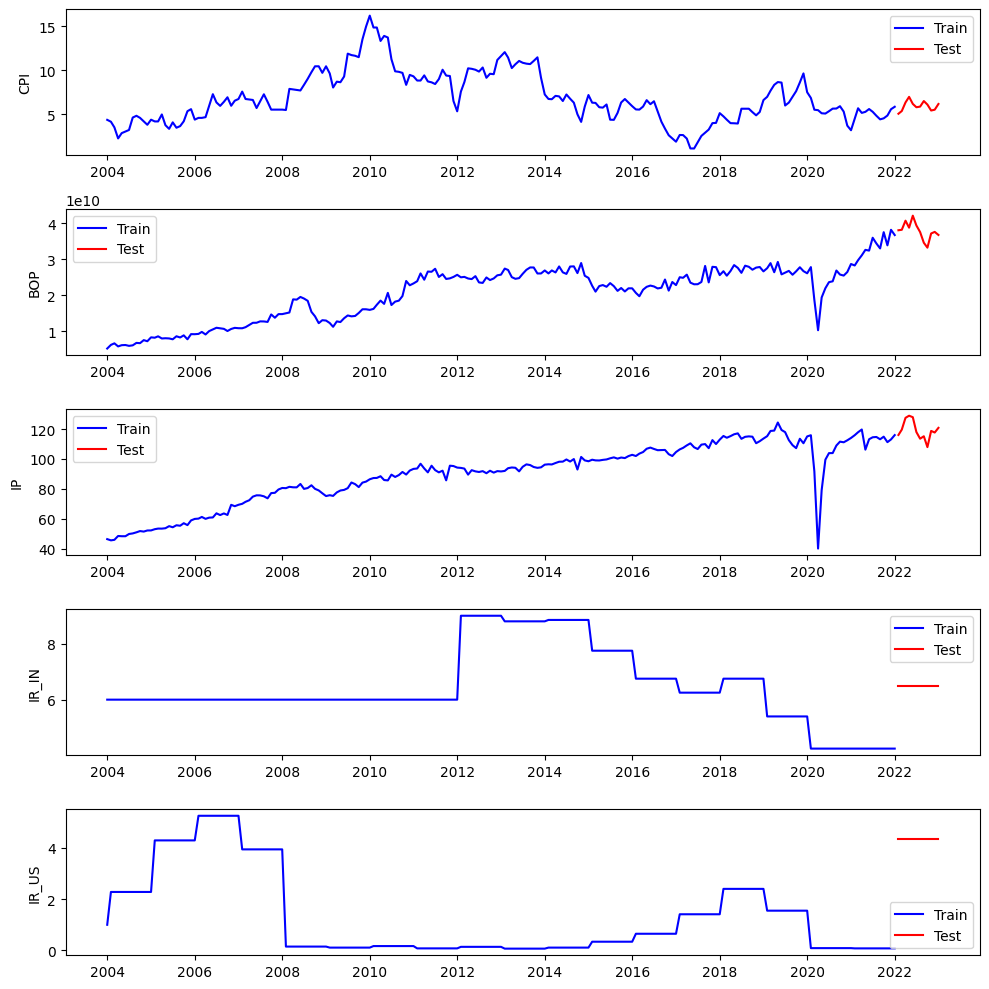

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10))

features = ['CPI', 'BOP', 'IP', 'IR_IN', 'IR_US']
colors = ['blue', 'red']
labels = ['Train', 'Test']

for i, feature in enumerate(features):
    ax = axes[i]
    ax.plot(X_train_df.index, X_train_df[feature], color=colors[0], label=labels[0])
    ax.plot(X_test_df.index, X_test_df[feature], color=colors[1], label=labels[1])
    ax.set_ylabel(feature)
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
X_train_df.shape

(217, 5)

In [ ]:
X_test_df.tail()

,CPI,BOP,IP,IR_IN,IR_US
DATE,,,,,
2022-09-01,6.488240,3.455579e+10,115.189011,6.5,4.33
2022-10-01,6.084868,3.319986e+10,107.920673,6.5,4.33
2022-11-01,5.409706,3.713571e+10,118.762478,6.5,4.33
2022-12-01,5.502392,3.757434e+10,117.675616,6.5,4.33
2023-01-01,6.155076,3.672524e+10,120.813889,6.5,4.33


In [ ]:
X_train_df.columns

Index(['CPI', 'BOP', 'IP', 'IR_IN', 'IR_US'], dtype='object')

In [ ]:

import pandas as pd
import numpy as np

# Calculate the correlation matrix
corr_matrix = X_train_df.corr()

# Set a threshold for high correlation
threshold = 0.7

# Create a mask to identify highly correlated pairs
mask = np.abs(corr_matrix) > threshold

# Get the column names of highly correlated pairs
highly_correlated_pairs = np.where(mask)
highly_correlated_pairs = [(X_train_df.columns[i], X_train_df.columns[j]) for i, j in zip(*highly_correlated_pairs) if i != j]

# Print the highly correlated pairs
print("Highly Correlated Pairs:")
for pair in highly_correlated_pairs:
    print(pair)

Highly Correlated Pairs:
('BOP', 'IP')
('IP', 'BOP')


In [ ]:
import statsmodels.api as sm

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_df.columns

vif_data["VIF"] = [sm.OLS(Y_train_df, sm.add_constant(X_train_df.drop(col, axis=1))).fit().rsquared for col in X_train_df.columns]
print(vif_data)
high_vif_cols = vif_data[vif_data['VIF'] > 10]['feature'].tolist()
print("Columns causing multicollinearity:", high_vif_cols)


  feature       VIF
0     CPI  0.631870
1     BOP  0.719990
2      IP  0.672553
3   IR_IN  0.719001
4   IR_US  0.712926
Columns causing multicollinearity: []


In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
X_scaler = StandardScaler()
X_scaler.fit(X_train_df)

Y_scaler = StandardScaler()
Y_scaler.fit(Y_train_df)

X_train_df_scaled = pd.DataFrame(X_scaler.transform(X_train_df),columns=['CPI', 'BOP', 'IP', 'IR_IN', 'IR_US'],index= X_train_df.index)
Y_train_df_scaled = pd.DataFrame(Y_scaler.transform(Y_train_df),columns=['USD/INR'],index= Y_train_df.index)

In [ ]:
X_train_df_scaled.head()

,CPI,BOP,IP,IR_IN,IR_US
DATE,,,,,
2004-01-01,-0.865564,-2.011614,-2.182804,-0.334049,-0.173745
2004-02-01,-0.940410,-1.879228,-2.223633,-0.334049,0.613264
2004-03-01,-1.163104,-1.822626,-2.206316,-0.334049,0.613264
2004-04-01,-1.600362,-1.934331,-2.078496,-0.334049,0.613264
2004-05-01,-1.391103,-1.889910,-2.086234,-0.334049,0.613264


In [ ]:
X_test_df_scaled = pd.DataFrame(X_scaler.transform(X_test_df),columns=['CPI', 'BOP', 'IP', 'IR_IN', 'IR_US'],index= X_test_df.index)
X_test_df_scaled.head()

,CPI,BOP,IP,IR_IN,IR_US
DATE,,,,,
2022-02-01,-0.624568,2.288075,1.280644,0.041151,1.873707
2022-03-01,-0.517242,2.305173,1.458841,0.041151,1.873707
2022-04-01,-0.178104,2.636043,1.850434,0.041151,1.873707
2022-05-01,0.043077,2.381645,1.921283,0.041151,1.873707
2022-06-01,-0.235513,2.818078,1.871803,0.041151,1.873707


In [ ]:
Y_test_df_scaled = pd.DataFrame(Y_scaler.transform(Y_test_df),columns=['USD/INR'],index= Y_test_df.index)
Y_test_df_scaled.head()

,USD/INR
Date,
2022-02-01,1.566017
2022-03-01,1.629016
2022-04-01,1.682976
2022-05-01,1.741723
2022-06-01,1.829006


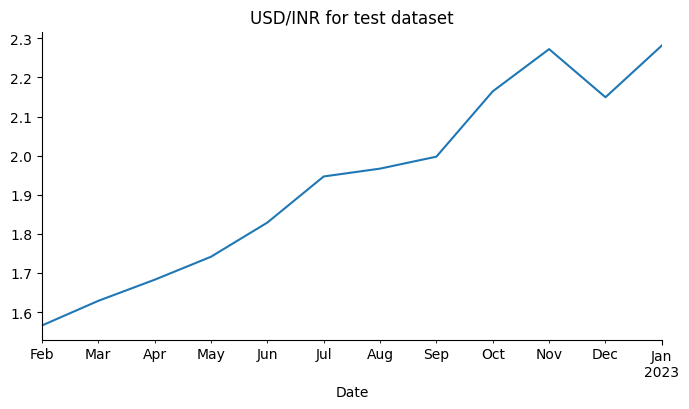

In [ ]:
from matplotlib import pyplot as plt
Y_test_df_scaled['USD/INR'].plot(kind='line', figsize=(8, 4),title='USD/INR for test dataset')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'epsilon': [0.1, 0.5, 1, 2, 5]
}

model = SVR()
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_df_scaled, Y_train_df_scaled.values.ravel())
best_params = grid_search.best_params_
best_model = SVR(**best_params)
best_model.fit(X_train_df_scaled, Y_train_df_scaled.values.ravel())
print(best_params)


{'C': 0.1, 'epsilon': 0.1, 'kernel': 'sigmoid'}


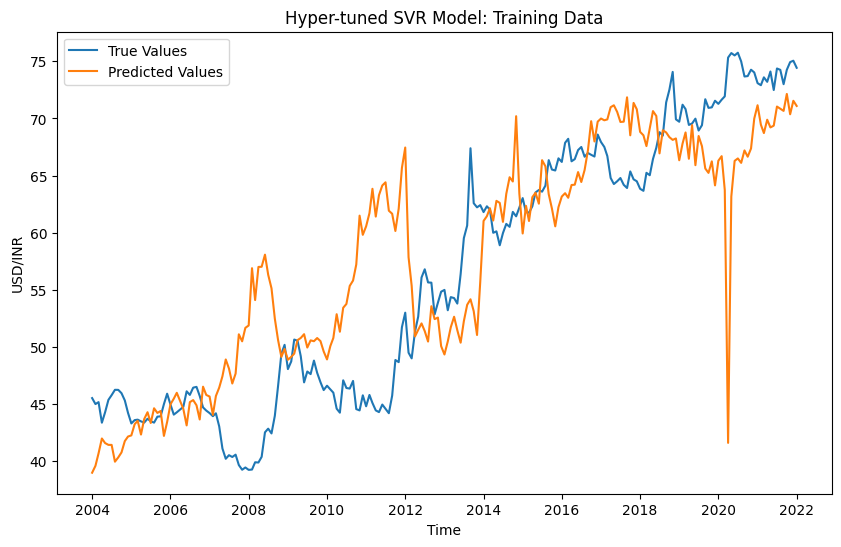

In [ ]:
train_predictions = best_model.predict(X_train_df_scaled)

train_predictions_inverse = Y_scaler.inverse_transform(train_predictions.reshape(-1, 1))
train_true_values_inverse = Y_scaler.inverse_transform(Y_train_df_scaled)

train_results_df = pd.DataFrame({'True Values': train_true_values_inverse.flatten(),
                                'Predicted Values': train_predictions_inverse.flatten()},
                               index=Y_train_df.index)
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_results_df, x=train_results_df.index, y='True Values', label='True Values')
sns.lineplot(data=train_results_df, x=train_results_df.index, y='Predicted Values', label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('USD/INR')
plt.title('Hyper-tuned SVR Model: Training Data')
plt.legend()
plt.show()


Mean Squared Error: 59.641294890673635


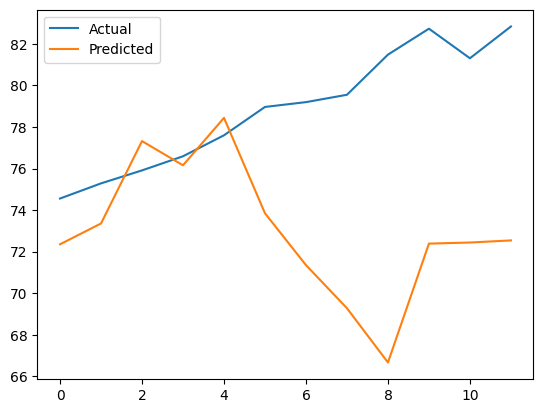

In [ ]:
from sklearn.metrics import mean_squared_error

Y_pred = best_model.predict(X_test_df_scaled)

Y_pred_inverse = Y_scaler.inverse_transform(Y_pred.reshape(-1, 1))
Y_test_df_inverse = Y_scaler.inverse_transform(Y_test_df_scaled)


mse_svm = mean_squared_error(Y_test_df_inverse, Y_pred_inverse)


print("Mean Squared Error:", mse_svm)


plt.plot(Y_test_df_inverse, label='Actual')
plt.plot(Y_pred_inverse, label='Predicted')
plt.legend()
plt.show()


In [ ]:
# pip install pmdarima

In [ ]:
from pmdarima import auto_arima
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima import ndiffs

adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(Y_train_df)
print(p_val, should_diff)

0.2046314303816209 True


In [ ]:
for column in X_train_df.columns:
  p_val , should_diff = adf_test.should_diff(X_train_df[column])
  print(column , p_val , should_diff)

CPI 0.45793431259802886 True
BOP 0.5292050538264531 True
IP 0.20036196478898796 True
IR_IN 0.9197327252772493 True
IR_US 0.6576395930272589 True


In [ ]:
kpss_diffs = ndiffs(Y_train_df, alpha=0.05, test='pp', max_d=6)
adf_diffs = ndiffs(Y_train_df, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print("Y_train", n_diffs)

Y_train 1


In [ ]:
for column in X_train_df.columns:
  kpss_diffs = ndiffs(Y_train_df, alpha=0.05, test='pp', max_d=6)
  adf_diffs = ndiffs(Y_train_df, alpha=0.05, test='adf', max_d=6)
  n_diffs = max(adf_diffs, kpss_diffs)
  print(column, n_diffs)

CPI 1
BOP 1
IP 1
IR_IN 1
IR_US 1


In [ ]:
X_train_df.values

array([[4.34782609e+00, 5.20111285e+09, 4.63836750e+01, 6.00000000e+00,
        1.00000000e+00],
       [4.13223140e+00, 6.21186882e+09, 4.55625360e+01, 6.00000000e+00,
        2.28000000e+00],
       [3.49075975e+00, 6.64401621e+09, 4.59108062e+01, 6.00000000e+00,
        2.28000000e+00],
       ...,
       [4.83736447e+00, 3.38426114e+10, 1.11242015e+02, 4.25000000e+00,
        8.00000000e-02],
       [5.55555556e+00, 3.81567668e+10, 1.13055946e+02, 4.25000000e+00,
        8.00000000e-02],
       [5.83756345e+00, 3.66966305e+10, 1.15966152e+02, 4.25000000e+00,
        8.00000000e-02]])

In [ ]:

model = auto_arima(y= Y_train_df.values, X=X_train_df.values,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True,
                      seasonal = False
      )

print(model.summary())


Performing stepwise search to minimize aic


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=729.635, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=721.544, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=723.435, Time=0.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=723.435, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1668.254, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=726.082, Time=1.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 5.673 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  217
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -353.772
Date:                Tue, 09 Apr 2024   AIC                            721.544
Time:                        01:04:49   BIC                            745.170
Sample:                             0   HQIC                           731.089
                                - 217                     

Mean Squared Error: 37.34912668011296


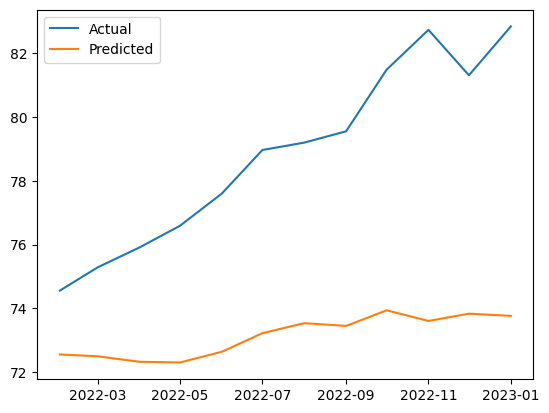

In [ ]:
Y_pred = model.predict(n_periods=12, X=X_test_df)
# Calculate the mean squared error
mse = mean_squared_error(Y_test_df, Y_pred)
print("Mean Squared Error:", mse)
# Plot the actual and predicted values
plt.plot(Y_test_df, label='Actual')
plt.plot(pd.DataFrame(Y_pred,index=Y_test_df.index), label='Predicted')
plt.legend()
plt.show()

Mean Squared Error: 37.34912668011296


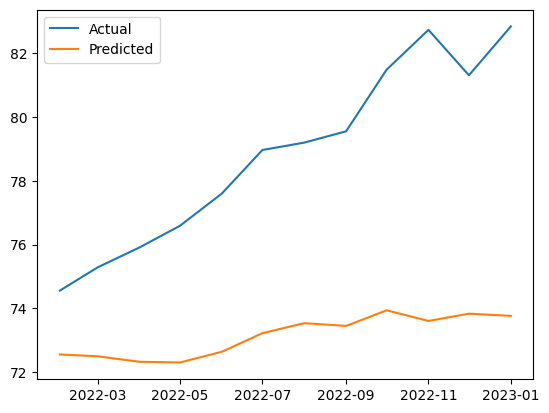

In [ ]:
# Calculate the mean squared error
mse_arima = mean_squared_error(Y_test_df, Y_pred)
print("Mean Squared Error:", mse_arima)
# Plot the actual and predicted values
plt.plot(Y_test_df, label='Actual')
plt.plot(pd.DataFrame(Y_pred,index=Y_test_df.index), label='Predicted')
plt.legend()
plt.show()

In [ ]:
percentage = ((mse_svm - mse_arima)/ mse_arima)*100
print(f"MSE of SVM model is {percentage:.0f}% higher than ARIMAX model")

MSE of SVM model is 60% higher than ARIMAX model
